# Housing price prediction - classification and regression problem

## Quick overview

This notebook will cover end-to-end process prototyping for solving both classification and regression problems based on house.csv dataset. Data contains sale offers of houses including many information about house itself and its surrounding.

This notebook will cover ML project from scratch: starting from EDA, prototyping preprocessing and modeling pipelines and then refactoring code to make it replicating.

<br>
<b>Github repo</b>: https://github.com/tizycki/house-pricing

## Author

Full name: Tomasz Iżycki

LinkedIn profile: https://www.linkedin.com/in/tomasz-izycki/

## 1. Setup and configuration

### 1.1 Import essential packages

In [1]:
# Data wrangling
import pandas as pd
import numpy as np

# Utils
import math
from datetime import datetime
from dateutil import parser
import pickle
import os.path

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data preparation
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Transformers
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder

# Pipeline and models
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.dummy import DummyClassifier, DummyRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import xgboost as xgb
from mlxtend.classifier import StackingCVClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR

# Metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, roc_curve, roc_auc_score

### 1.2 Set global configuration

In [2]:
# Set global constants
SEED = 42
DATA_PATH = "./data/house.csv"

### 1.3 Load raw data

In [3]:
df_raw = pd.read_csv(DATA_PATH)

## 2. Explanatory Data Analysis - EDA

### 2.1 General overview

Let's take a look into our input data

In [4]:
df_raw.head(5)

,id,date,price,price_bin,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,0,3,1.00,1180,5650,1.0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,0,3,2.25,2570,7242,2.0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,0,2,1.00,770,10000,1.0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,0,4,3.00,1960,5000,1.0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,0,3,2.00,1680,8080,1.0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [5]:
df_raw.shape

(21613, 22)


Let's investigate if we have only unique sale offers in our dataset

In [6]:
#assert data_raw.shape[0] == data_raw['id'].nunique()
print(f"Number of rows: {df_raw.shape[0]}\nNumber of unique IDs: {df_raw['id'].nunique()}")

Number of rows: 21613
Number of unique IDs: 21436


We have duplicates in our data. We'll get the latest (based on 'date') row (sales offer) per ID.

In [7]:
unique_idx = df_raw.reset_index().sort_values(['id', 'date'], ascending=False).groupby('id')['index'].first()
data_raw = df_raw[df_raw.index.isin(unique_idx)]

print(f"Number of rows: {data_raw.shape[0]}\nNumber of unique IDs: {data_raw['id'].nunique()}")

Number of rows: 21436
Number of unique IDs: 21436


And now investigate features and check their types. Then take a moment to study them using additional information contained in .pdf file

In [8]:
data_raw.dtypes

id                 int64
date              object
price            float64
price_bin          int64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

### 2.2 Target variables

Let's get look into our target variables - for both classification and regression problem. How is price distrubuted? Do we have a problem of unbalanced classes for classification problem?

In [9]:
def continuous_var_plot(var_data: pd.Series, col_name: str) -> None:
    """
    Plot histogram and box-plot of continuous feature. In addition, marks mean, median, q95 and q99.5.
    
    args:
        var_data - pd.Series to plot
        col_name - string name of column
    
    return: None
    """
    
    # Set figure
    fig, axis = plt.subplots(
        nrows=2, 
        ncols=1, 
        figsize=(12, 8),
        sharex=True, 
        gridspec_kw={"height_ratios": (0.2, 1)}
    )
    fig.suptitle(
        'Distribution of price', 
        fontsize='xx-large'
    )
    # Plot data
    sns.boxplot(var_data, ax=axis[0])
    sns.distplot(var_data, ax=axis[1])

    # Set axes
    stats = {
        'Mean': var_data.mean(), 
        'Median': var_data.median(), 
        'q95': var_data.quantile(q=0.95),
        'q99.5': var_data.quantile(q=0.995)
    }
    for ax in axis:
        for stat, color in zip(stats.values(), ['r', 'g', 'b', 'purple']):
            ax.axvline(stat, color=color, linestyle='--')    

    plt.legend(stats)
    axis[0].set(xlabel='')

    del stats
    
    return None

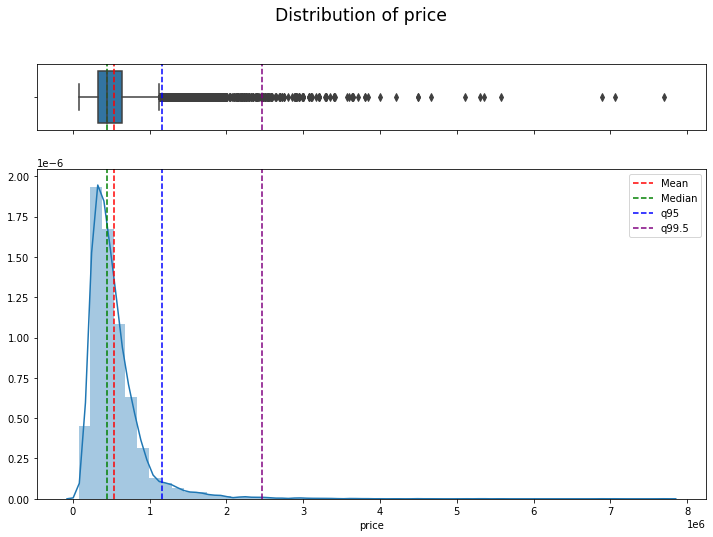

In [10]:
continuous_var_plot(data_raw.price, 'price')

In [11]:
data_raw[['price', 'price_bin']].describe()

,price,price_bin
count,2.143600e+04,21436.000000
mean,5.417449e+05,0.068063
std,3.675513e+05,0.251860
min,7.500000e+04,0.000000
25%,3.248660e+05,0.000000
50%,4.500000e+05,0.000000
75%,6.450000e+05,0.000000
max,7.700000e+06,1.000000


As we can notice, we're dealing with highly skewed and heavy tailed distribution of price which will have an effect of our future regressor. In this case we'll consider removing or modifying extreme values. We'll as well consider to apply transformations to our 

In case of classification problem we're dealing with highly extreme class inbalance. We'll try to mitigate that problem by applying oversampling techniques in further part.

As a next step, we'll investigate explanatory features. But before we do that let's split our dataset into training and test to prevent any information leakage.

### 2.3 Features configuration

At the beginning we'll treat features as 'view', 'condition' etc. as categorical cols, because we didn't check yet if higher value stands for better status (better view, condition etc.).

In [12]:
technical_cols = [
    'id'
]

target_cols = {
    'classification': 'price_bin',
    'regression': 'price'
}

continuous_cols = [
    'sqft_living',
    'sqft_living15',
    'sqft_lot',
    'sqft_lot15',
    'sqft_above',
    'sqft_basement',
    'yr_built',
    'yr_renovated',
    'lat',
    'long'
]

numerical_discrete_cols = [
    'bedrooms',
    'bathrooms',
    'floors',
    'grade',
    'view'
]

categorical_cols = [
    'date',
    'waterfront',
    'condition',
    'zipcode'
]

non_trainable_cols = technical_cols + list(target_cols.values())
trainable_cols = continuous_cols + numerical_discrete_cols + categorical_cols

Let's be sure that we didn't ommit any variable

In [13]:
diff = [col for col in data_raw.columns if col not in (trainable_cols + non_trainable_cols)]

if len(diff) != 0:
    print(f'Those columns were not assigned to any group:\n{diff}')
assert len(diff) == 0

del diff

### 2.4 Split data in Train and Test

We'll split our dataset into 80/20 (train/test), using the same split for both classification and regression models

In [14]:
X = data_raw.loc[:, trainable_cols]
y_all = data_raw.loc[:, list(target_cols.values())]

X_train, X_test, y_all_train, y_all_test = train_test_split(X, y_all, test_size=0.2, random_state=SEED)

del X
del y_all

### 2.5 Analyze explanatory features

In [15]:
X_train[continuous_cols].head(5)

,sqft_living,sqft_living15,sqft_lot,sqft_lot15,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long
5300,1670,1800,14695,11355,1670,0,1930,0,47.7001,-122.200
11670,1100,1380,11824,11796,1100,0,1954,0,47.5704,-122.141
21329,1440,1440,1102,1434,1440,0,2009,0,47.6995,-122.346
6672,2830,2970,9680,8691,2830,0,1991,0,47.6249,-122.024
5318,1640,1420,17583,11680,1110,530,1969,0,47.7260,-122.203


In [16]:
X_train[continuous_cols].describe()

,sqft_living,sqft_living15,sqft_lot,sqft_lot15,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long
count,17148.000000,17148.000000,1.714800e+04,17148.000000,17148.000000,17148.000000,17148.000000,17148.000000,17148.000000,17148.000000
mean,2086.006998,1985.895498,1.502340e+04,12670.810182,1793.805108,292.201889,1971.138383,85.552718,47.560650,-122.213849
std,923.680777,685.734299,4.061309e+04,27176.942703,832.930408,442.854551,29.422482,404.306362,0.137892,0.141361
min,290.000000,460.000000,5.200000e+02,651.000000,290.000000,0.000000,1900.000000,0.000000,47.155900,-122.519000
25%,1430.000000,1490.000000,5.040000e+03,5100.000000,1200.000000,0.000000,1952.000000,0.000000,47.472600,-122.329000
50%,1920.000000,1840.000000,7.609500e+03,7611.000000,1570.000000,0.000000,1975.000000,0.000000,47.572300,-122.231000
75%,2560.000000,2360.000000,1.066425e+04,10080.000000,2220.000000,560.000000,1997.000000,0.000000,47.678025,-122.124000
max,12050.000000,6210.000000,1.164794e+06,871200.000000,8860.000000,3500.000000,2015.000000,2015.000000,47.777600,-121.315000


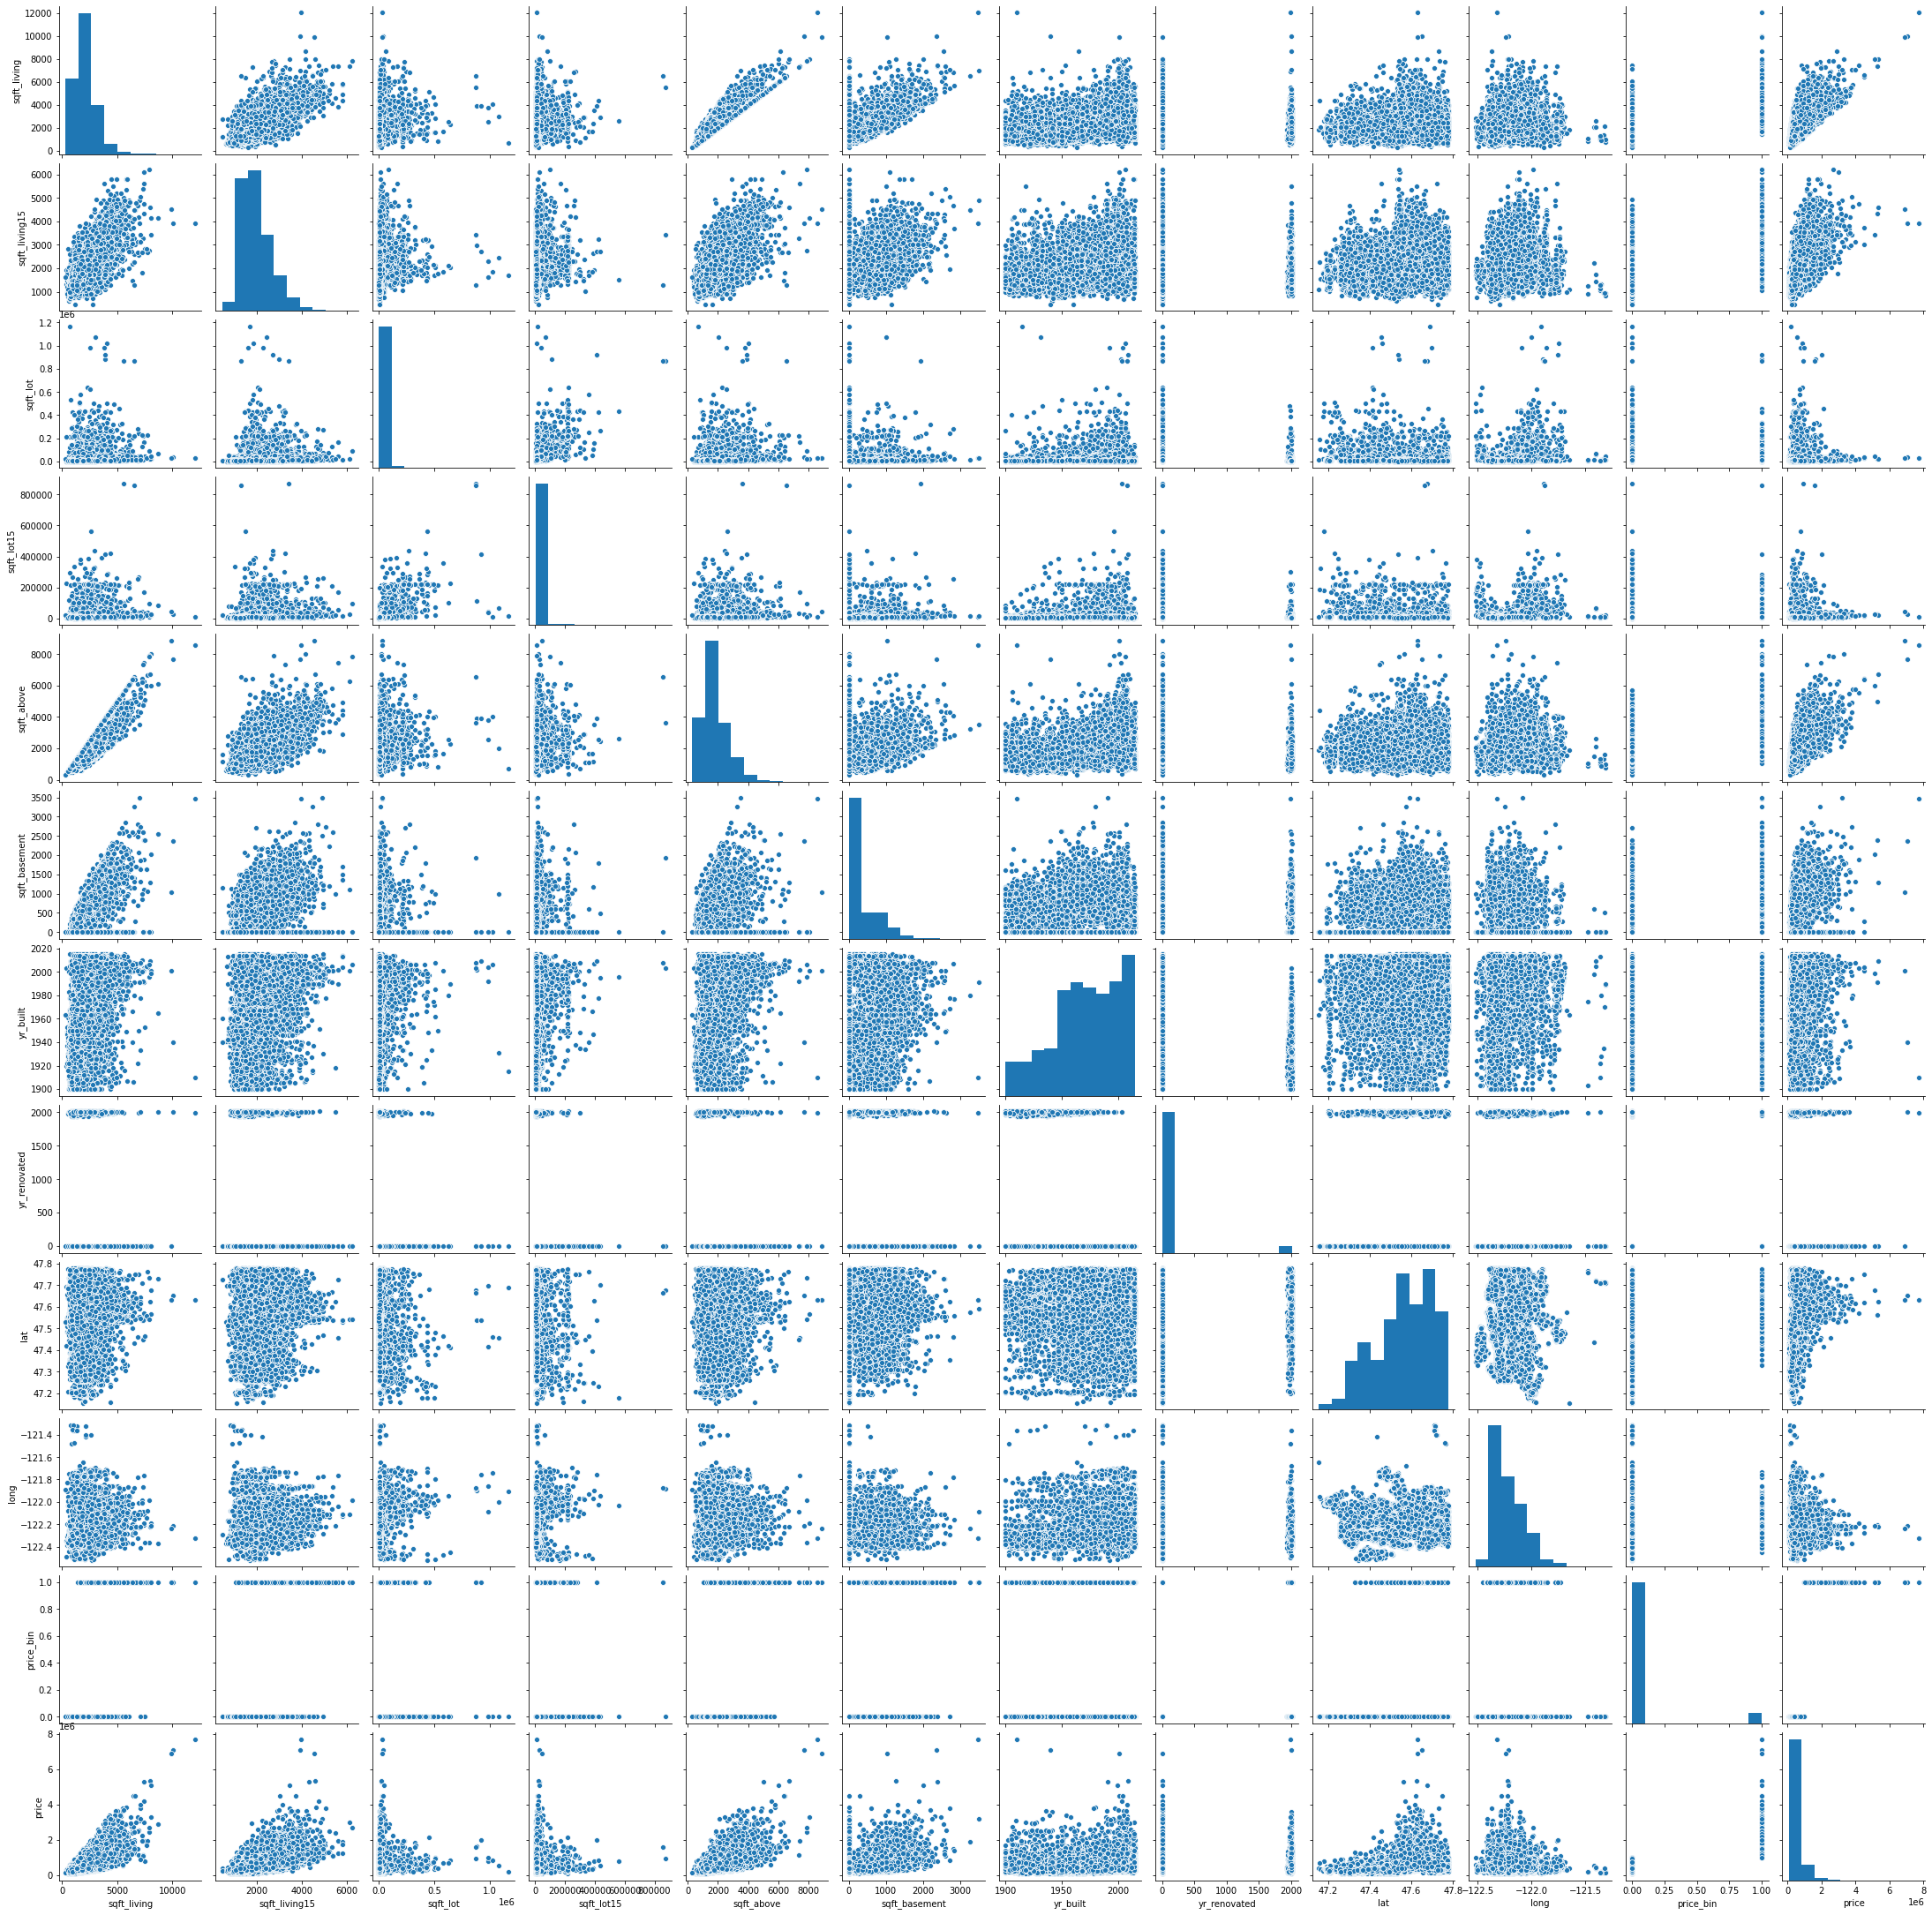

In [17]:
sns.pairplot(pd.concat([X_train[continuous_cols], y_all_train], axis=1))

In [18]:
X_train[numerical_discrete_cols].head(5)

,bedrooms,bathrooms,floors,grade,view
5300,2,1.00,1.5,7,0
11670,4,1.50,1.0,7,0
21329,3,2.50,3.0,8,0
6672,3,2.50,2.0,10,0
5318,3,1.75,1.0,7,0


In [19]:
X_train[numerical_discrete_cols].describe()

,bedrooms,bathrooms,floors,grade,view
count,17148.000000,17148.000000,17148.000000,17148.000000,17148.000000
mean,3.373105,2.121953,1.499329,7.669174,0.240495
std,0.934892,0.773818,0.539604,1.178535,0.776326
min,0.000000,0.000000,1.000000,1.000000,0.000000
25%,3.000000,1.750000,1.000000,7.000000,0.000000
50%,3.000000,2.250000,1.500000,7.000000,0.000000
75%,4.000000,2.500000,2.000000,8.000000,0.000000
max,33.000000,8.000000,3.500000,13.000000,4.000000


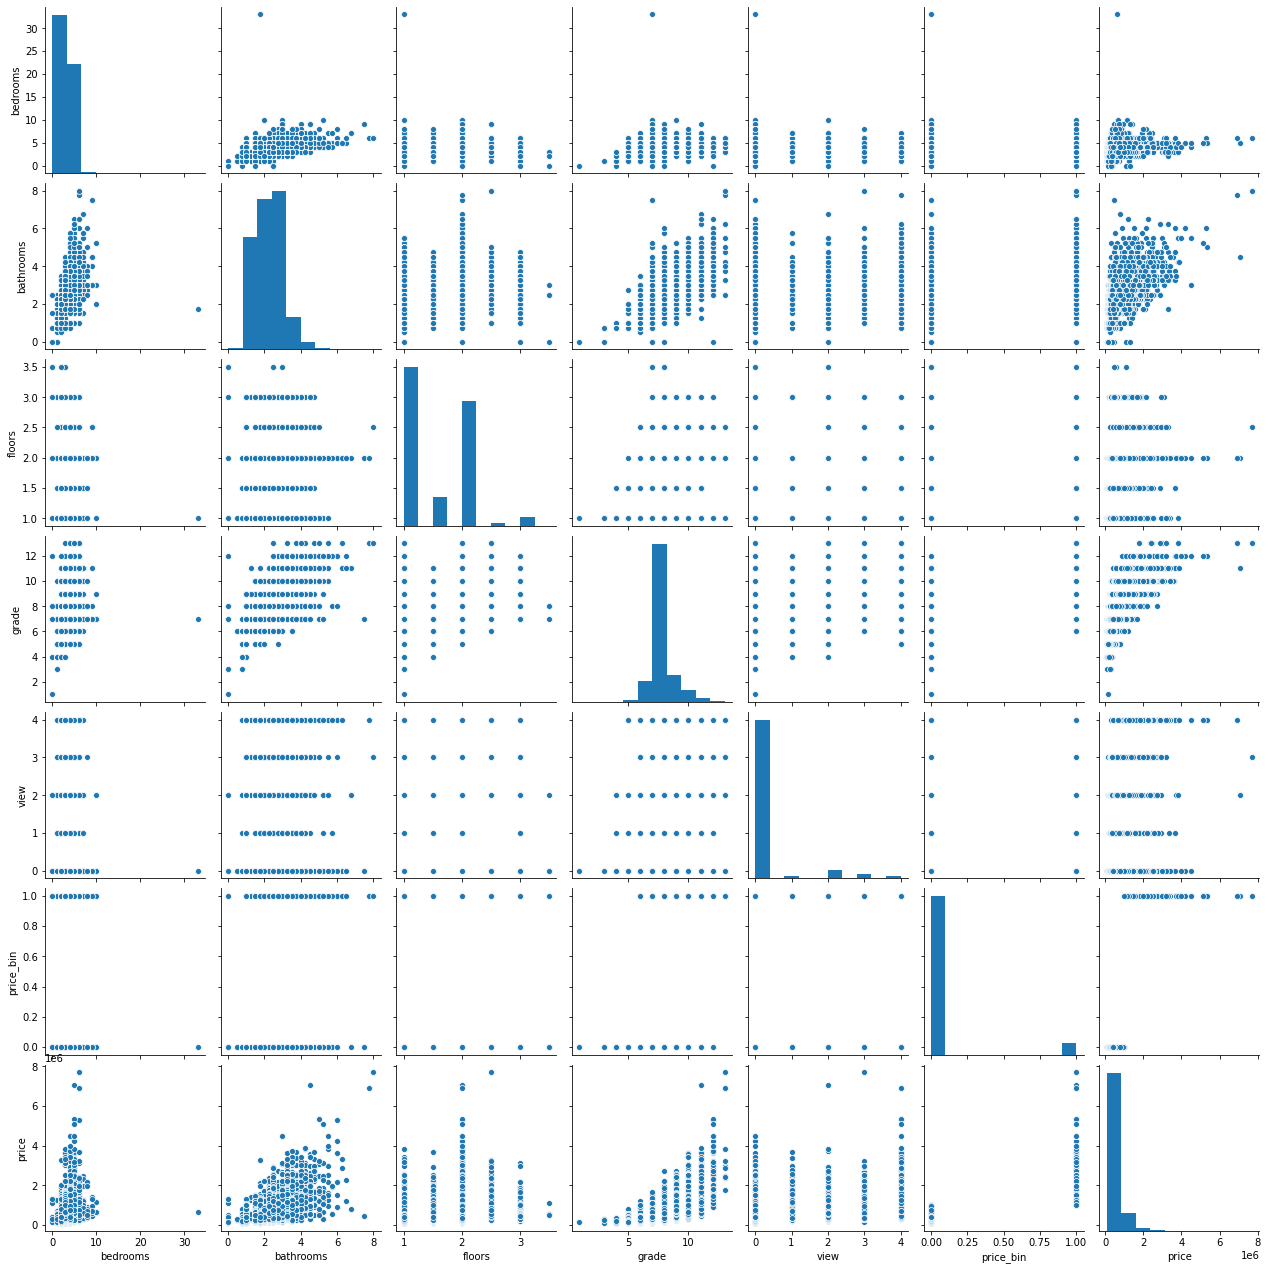

In [20]:
sns.pairplot(pd.concat([X_train[numerical_discrete_cols], y_all_train], axis=1))

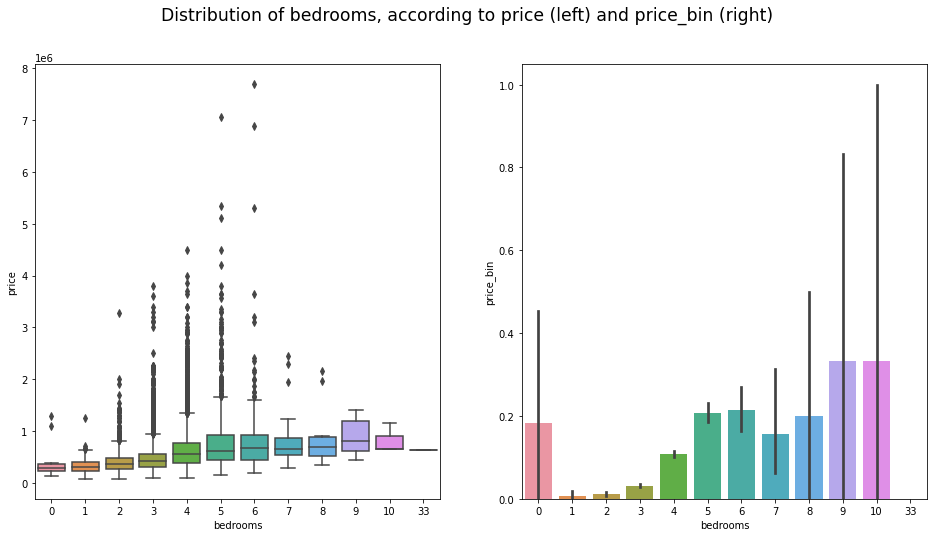

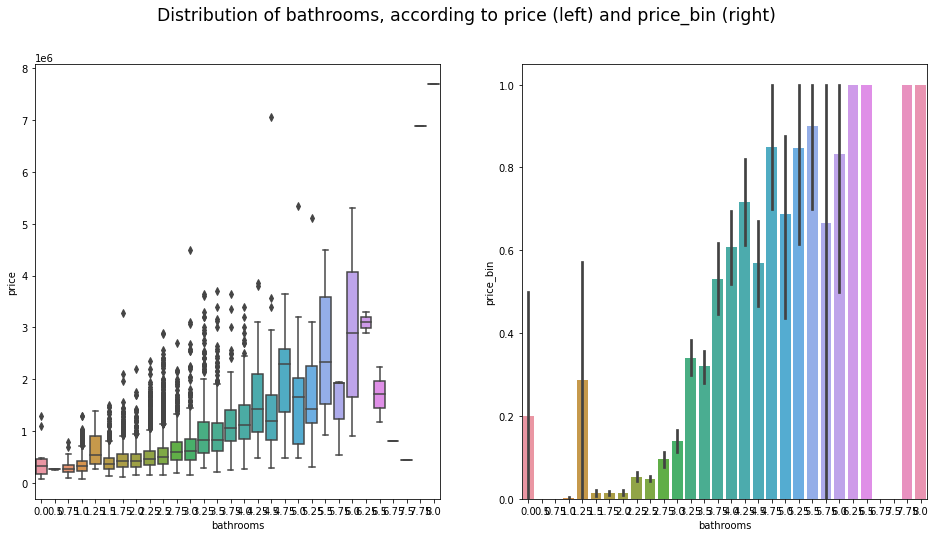

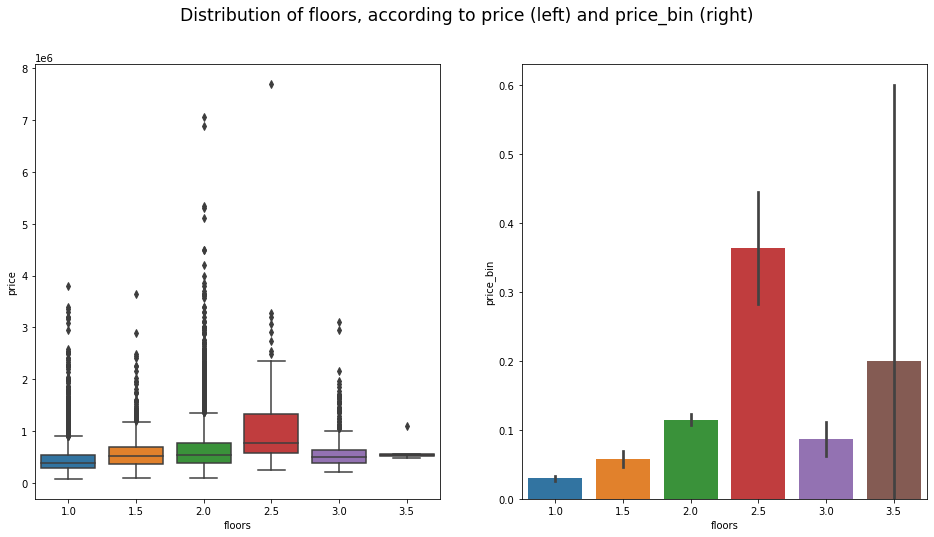

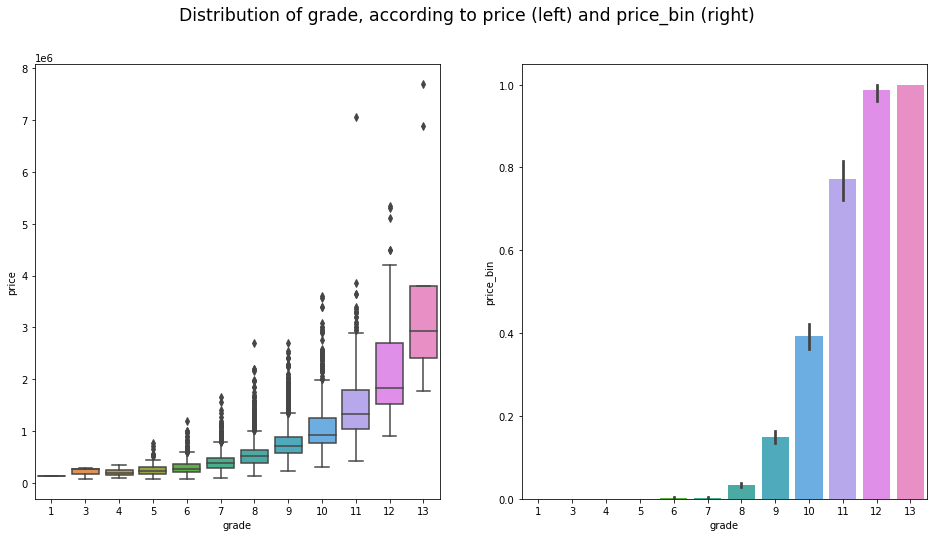

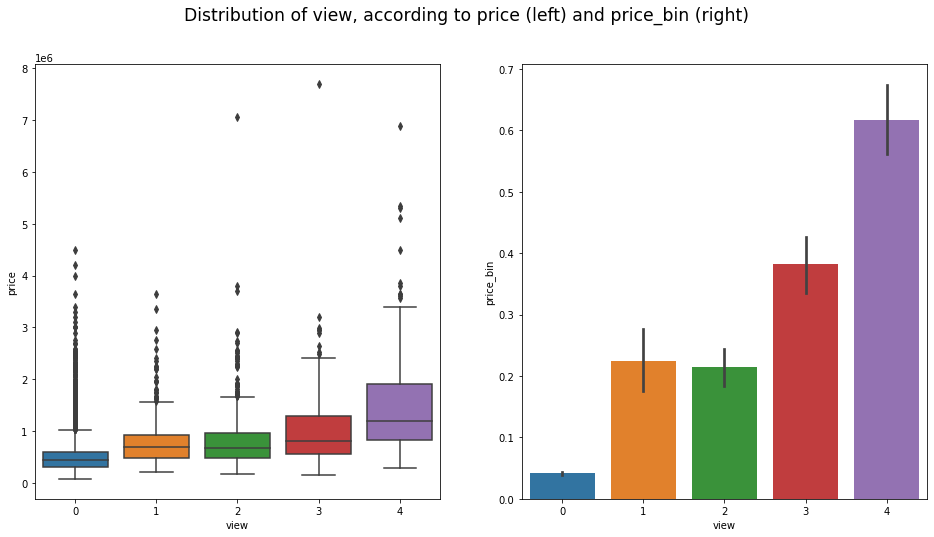

In [21]:
for col in numerical_discrete_cols:
    fig, axis = plt.subplots(
        nrows=1, 
        ncols=2, 
        figsize=(16, 8),
        gridspec_kw={"width_ratios": (0.5, 0.5)}
    )
    fig.suptitle(
        f'Distribution of {col}, according to price (left) and price_bin (right)', 
        fontsize='xx-large'
    )
    sns.boxplot(x=X_train[col], y=y_all_train[target_cols['regression']], ax=axis[0])
    sns.barplot(x=X_train[col], y=y_all_train[target_cols['classification']], ax=axis[1])

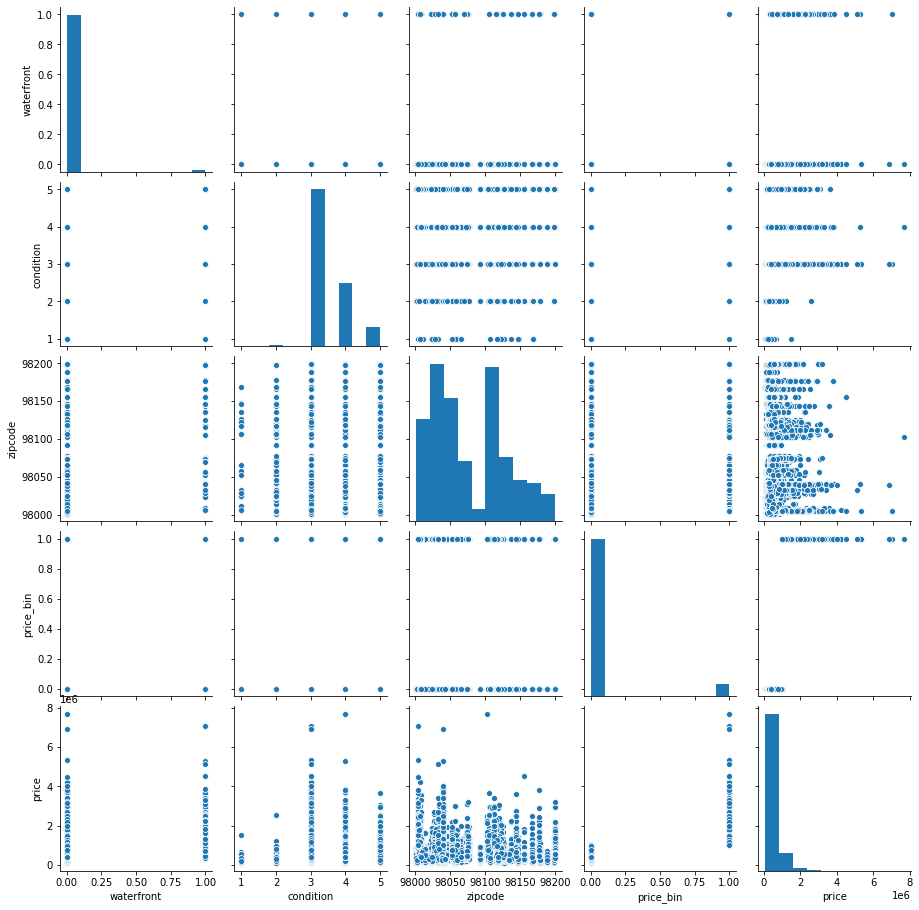

In [22]:
sns.pairplot(pd.concat([X_train[categorical_cols], y_all_train], axis=1))

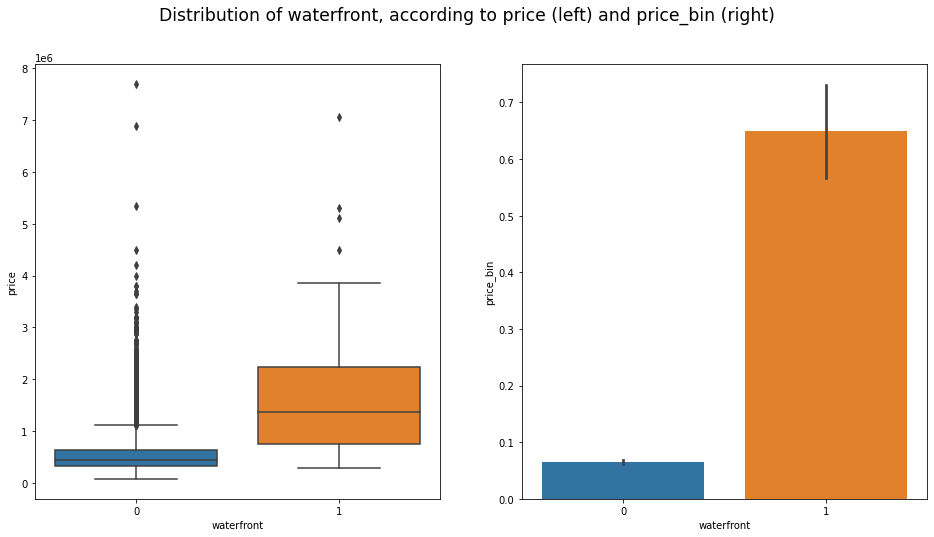

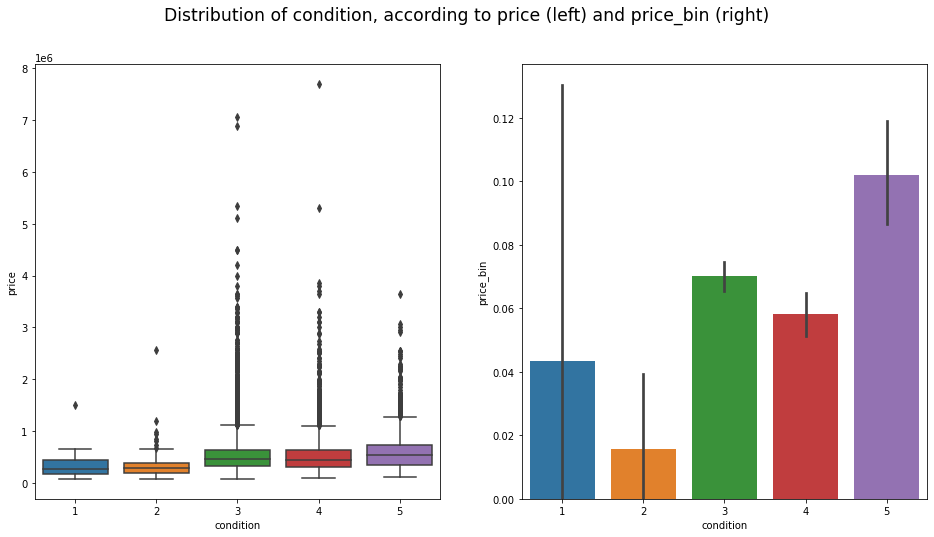

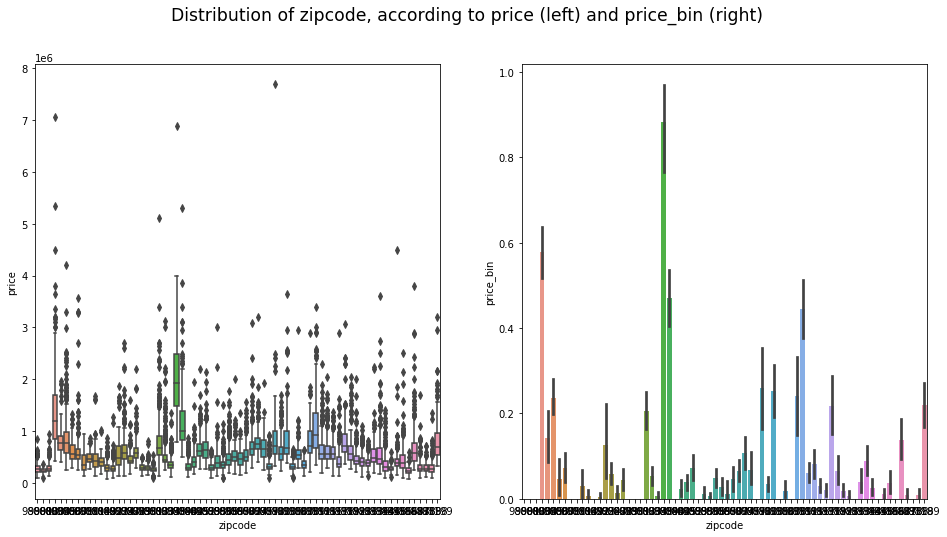

In [23]:
for col in [x for x in categorical_cols if x != 'date']:
    fig, axis = plt.subplots(
        nrows=1, 
        ncols=2, 
        figsize=(16, 8),
        gridspec_kw={"width_ratios": (0.5, 0.5)}
    )
    fig.suptitle(
        f'Distribution of {col}, according to price (left) and price_bin (right)', 
        fontsize='xx-large'
    )
    sns.boxplot(x=X_train[col], y=y_all_train[target_cols['regression']], ax=axis[0])
    sns.barplot(x=X_train[col], y=y_all_train[target_cols['classification']], ax=axis[1])

(670, 879, 4)


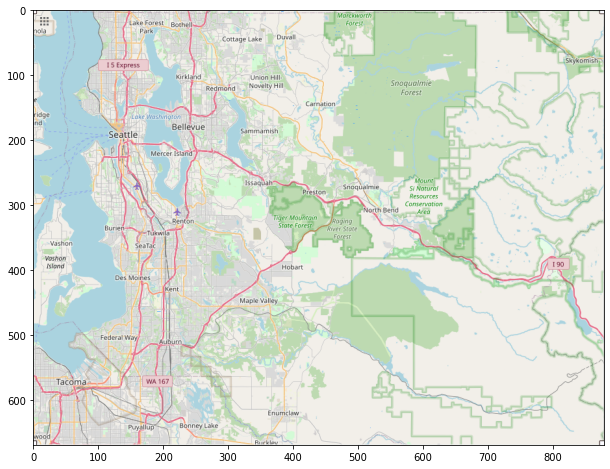

In [24]:
background_map = plt.imread('./map-background.png')
print(background_map.shape)

plt.figure(figsize=(12, 8))
plt.imshow(background_map)

According to investigation of this batch of features we can articulate the following conclusions:

- Due to lack of information in a provided document, about differentiation of the following pairs of columns (sqft_living, sqft_living15), (sqft_lot, sqft_lot15) we'll exclude one feature of each pair. It's a safety measure to not work with information that has no exact interpretation.
- Sum of features sqft_above and sqft_basement contain exactly the same information as sqft_living. Those features require transformation - e.g. size of basement according to size of the whole house (%) 
- Outliers has to investigated for the following features: price, bedrooms, bathrooms, sqft_lot
- Number of bathrooms are not integer values. We'll assume that size of the bathroom was included into that measure. 
- We'll take care about date transformation and feature engineering based on that feature later on.
- Discrete features with high number of classes will be transformed using target encoding. 
- We'll transform continuous features using either Box-Cox transformation or log-scaling.
- Houses are very spread across huge area are so we'll not decide to create any additional features (schools in X meters, distance to closes park/sea) based on that. We'll keep it as a thing to do in the future becuase it would be very time consuming process.

### 2.6 Missing values

In [25]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21436 entries, 0 to 21612
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21436 non-null  int64  
 1   date           21436 non-null  object 
 2   price          21436 non-null  float64
 3   price_bin      21436 non-null  int64  
 4   bedrooms       21436 non-null  int64  
 5   bathrooms      21436 non-null  float64
 6   sqft_living    21436 non-null  int64  
 7   sqft_lot       21436 non-null  int64  
 8   floors         21436 non-null  float64
 9   waterfront     21436 non-null  int64  
 10  view           21436 non-null  int64  
 11  condition      21436 non-null  int64  
 12  grade          21436 non-null  int64  
 13  sqft_above     21436 non-null  int64  
 14  sqft_basement  21436 non-null  int64  
 15  yr_built       21436 non-null  int64  
 16  yr_renovated   21436 non-null  int64  
 17  zipcode        21436 non-null  int64  
 18  lat   

We don't have any missing values in our dataset. Therefore no additional steps are needed.
If any would exist, we'll try to impute them using constant, mean, median or classification model (e.g. Random Forest)

### 2.7 Outliers

Let's investigate outliers for following features:
- price, 
- bedrooms, 
- bathrooms, 
- sqft_lot

Another things that we would consider to deal with outliers would be value capping (e.g. if x > q99_95: x = q99_95) but it was decided to remove those values from our dataset.

In [26]:
extreme_values = dict()

for col in ['price', 'bedrooms', 'bathrooms', 'sqft_lot']:
    if col == 'price':
        q99_95 = y_all_train[col].quantile(q=0.9995)
        df_q99_95 = y_all_train[y_all_train[col] > q99_95]
    else:
        q99_95 = X_train[col].quantile(q=0.9995)
        df_q99_95 = X_train[X_train[col] > q99_95]
    
    extreme_values[col] = {
        'q99.95': q99_95,
        'n_rows': df_q99_95.shape[0]
    }

del q99_95
del df_q99_95

In [27]:
pd.DataFrame(extreme_values).transpose()

,q99.95,n_rows
price,4.089565e+06,9.0
bedrooms,9.000000e+00,4.0
bathrooms,6.000000e+00,8.0
sqft_lot,7.392967e+05,9.0


Let's create a transformer to remove those outliers and test it.

In [28]:
class OutlierRemovalDF(BaseEstimator, TransformerMixin):
    """
    Remove outliers from both X and y dataframes based on specified column names and their cap values (quantile)
    
    Args:
        config_dict: Dictionary with specified features and their cap values
    Returns:
        X: pd.DataFrame with removed outliers
        y: pd.DataFrame/pd.Series with removed outliers
    """
    
    def __init__(self, config_dict, verbose=0):
        self.__config_dict = config_dict
        self.__outlier_config = dict()
        self.__verbose = verbose
    
    def fit(self, X, y=None):        
        # Calculate features' cap values and save row indexes to remove
        for col, quantile in zip(self.__config_dict.keys(), self.__config_dict.values()):
            if col == 'price':
                q99_95 = y.quantile(q=quantile)
                self.__outlier_config[col] = q99_95
            else:
                q99_95 = X[col].quantile(q=quantile)
                self.__outlier_config[col] = q99_95
        del q99_95
        
        return self

    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        remove_idx = []
        for col, value in zip(self.__outlier_config.keys(), self.__outlier_config.values()):
            if col == 'price':
                remove_idx += list(y[(y > value)].index)
            else:
                remove_idx += list(X[(X[col] > value)].index)
                
        if self.__verbose > 0:
            print(f'Removed indexes:\n{remove_idx}')
            print(f'\nConfiguration for outlier removal:\n{self.__outlier_config}')
            
        return X[~(X.index.isin(remove_idx))], y[~(y.index.isin(remove_idx))]

In [29]:
# Outlier removal config
outlier_config = {
    'price': 0.9995,
    'bedrooms': 0.9995,
    'bathrooms': 0.9995,
    'sqft_lot': 0.9995
}

# Fit transformer
outlier = OutlierRemovalDF(outlier_config, verbose=1)
outlier.fit(X_train, y_all_train[target_cols['regression']])

# Check results
Xt, yt = outlier.transform(X_train, y_all_train[target_cols['regression']])

Removed indexes:
[1315, 12370, 3914, 9254, 7252, 8638, 2626, 1448, 1164, 15870, 15161, 13314, 19254, 8546, 18302, 21506, 9254, 4024, 7252, 14556, 20578, 4441, 7647, 7077, 7769, 17319, 3949, 9714, 20452, 6691]

Configuration for outlier removal:
{'price': 4089565.0000002934, 'bedrooms': 9.0, 'bathrooms': 6.0, 'sqft_lot': 739296.7205003214}


## 3. Base preprocessing (for both classification and regression problem)

### 3.0 Feature selection utils

In [30]:
class FeatureSelectorDF(BaseEstimator, TransformerMixin):
    """
    Simple feature selector that takes DataFrame as an input and returns pd.DataFrame aswell
    
    Args:
        feature_names - list of feature names to keep in DataFrame
    Returns:
        Dataframe with selected features
    """
    
    def __init__(self, feature_names):
        self.__feature_names = feature_names
    
    def fit(self, X):
        return self 
    
    def get_feature_names(self):
        return self.__feature_names
    
    def transform(self, X):
        return pd.DataFrame(X[self.__feature_names])

### 3.1 Label-target encoding

For categorical features with large number of classes we'll apply target encoding instead of one-hot encoding to not increase extremly our dimensionality. Below we'll implement that transformer and perform some simple tests.

In [31]:
class TargetEncoderDF(BaseEstimator, TransformerMixin):
    """
    Custom target encoder - converts categorical features into discrete distributed numerical feature.
    Function takes pd.DataFrame as an input.
    
    Args:
        features: list of features to encode with target encoder
        target_col: column name of target variable
        strategy: strategy for target encoding
            'mean': calculate mean of target variable per each class
    Returns:
        pd.DataFrame with encoded features (original values are replaced)
    """
    
    def __init__(self, features, target_col, strategy='mean') -> None:
        self.__features = features
        self.__strategy = strategy
        self.__target_col = target_col
        self.__aggregates = {}
    
    def fit(self, X: pd.DataFrame) -> pd.DataFrame:
        if self.__strategy == 'mean':
            for feature in self.__features:
                self.__aggregates[feature] = X.groupby(feature)[self.__target_col].agg(mean=np.mean)['mean'].to_dict()
                
                for key in self.__aggregates[feature].keys():
                    if self.__aggregates[feature][key] == np.nan:
                        self.__aggregates[feature][key] = 0
        else:
            raise NotImplementedError("That strategy is not implemented yet")

        return self
    
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        for feature in self.__features:
            X[feature] = X[feature].map(self.__aggregates[feature])
        
        return X[self.__features]

In [32]:
target_encoder = TargetEncoderDF(['zipcode'], target_cols['classification'], strategy='mean')
X_temp = pd.concat([X_train, y_all_train[target_cols['classification']]], axis=1)

target_encoder.fit(X_temp)

test = target_encoder.transform(X_temp)
test

,zipcode
5300,0.206897
11670,0.237113
21329,0.034836
6672,0.064706
5318,0.052506
...,...
11383,0.088028
12069,0.019753
5432,0.039046
868,0.019753


### 3.2 One-hot encoding

Below we'll use standard OneHotEncoder from sklearn library, and the apply custom transformer to 

In [33]:
class OneHotEncoderDF(BaseEstimator, TransformerMixin):
    """
    Function takes pd.DataFrame and apply sklearn.preprocessing.OneHotEncoder. After that, converts them to 
    pd.DataFrame and recreate feature/column names after one-hot-encoding
    
    Args:
        handle_unknown: option that specifies how to treat unknown categories while transforming dataframe.
            All options of handle_unknown from sklearn.preprocessing.OneHotEncoder are applicable
    Returns:
        pd.DataFrame with one-hot-encoded features with column names that specifies original column name and class
    """
    
    def __init__(self, handle_unknown='ignore') -> None:
        self.__handle_unknown = handle_unknown
        self.__input_feature_names = []
        self.__output_feature_names = []
        self.__one_hot_encoder = None
    
    def fit(self, X: pd.DataFrame) -> pd.DataFrame:
        # Save input, raw feature names
        self.__input_feature_names = list(X.columns)
        
        # Fit and save OneHotEncoding transformer
        one_hot_encoder = OneHotEncoder(handle_unknown=self.__handle_unknown)
        one_hot_encoder.fit(X)
        self.__one_hot_encoder = one_hot_encoder
                
        return self
    
    def get_feature_names(self) -> list:
        return self.__output_feature_names
    
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        # Apply transformer
        Xt = self.__one_hot_encoder.transform(X)
        
        # Set results back to DF with recovering of column names
        self.__categories = self.__one_hot_encoder.categories_
        self.__output_feature_names = []
        for feature, categories in zip(self.__input_feature_names, self.__categories):
            for category in categories:
                self.__output_feature_names.append(feature + '_' + str(category).replace('.', '_'))
                
        Xt = pd.DataFrame(Xt.toarray(), index=X.index, columns=self.__output_feature_names)
        
        return Xt

In [34]:
oh_enc = OneHotEncoderDF(handle_unknown='ignore')
oh_enc.fit(X_train[['floors', 'view']])
test = oh_enc.transform(X_train[['floors', 'view']])

test

,floors_1_0,floors_1_5,floors_2_0,floors_2_5,floors_3_0,floors_3_5,view_0,view_1,view_2,view_3,view_4
5300,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
11670,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
21329,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
6672,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5318,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
11383,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12069,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5432,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
868,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### 3.3 Log-scaling

In [35]:
class LogTransformerDF(BaseEstimator, TransformerMixin):
    """
    Custom log transformer for specified columns in DataFrame

    Args:
        features: list of features which has to be log-transformed (np.log)
    Returns:
        pd.DataFrame with transformed features (suffix: '_log') and dropped original values
    """
    
    def __init__(self, features, drop_features=True):
        self.__transform_features = features
        self.__drop_features = drop_features
        self.__aggregates = {}
        self.__features = []

    def fit(self, X: pd.DataFrame):
        self.__features = X.columns.tolist()
        for feature in self.__transform_features:
            self.__aggregates[feature] = {'min': X[feature].min()}
            
        return self

    def get_feature_names(self):
        return self.__features

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        Xt = X.copy()
        
        # Apply log-scaling and drop original feature if requested
        for feature in self.__transform_features:
            Xt[feature + '_log'] = np.log(np.maximum(Xt[feature] - self.__aggregates[feature]['min'], 0) + 1)          
            if self.__drop_features:
                Xt = Xt.drop(feature, axis=1)
            
        self.__features = Xt.columns.tolist()

        return Xt

In [36]:
log_transformer = LogTransformerDF(['bedrooms'], drop_features=False)
log_transformer.fit(X_train)

test = log_transformer.transform(X_test.loc[:, ['bedrooms']])
test

,bedrooms,bedrooms_log
6355,4,1.609438
20958,4,1.609438
1226,3,1.386294
1927,3,1.386294
17776,3,1.386294
...,...,...
2829,3,1.386294
9287,2,1.098612
21265,3,1.386294
17177,3,1.386294


### 3.4 Feature Engineering

In [37]:
class FeatureEngineeringDF(BaseEstimator, TransformerMixin):
    """
    Transformer applies data transformation and feature engineering. 
    """
    
    def __init__(self):
        pass

    def fit(self, X: pd.DataFrame, y=None):
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        Xt = X.copy()
        drop_cols = []
        
        # Date transformation
        Xt['date'] = Xt.date.apply(lambda x: parser.parse(x))
        Xt['view'] = Xt['view'].astype(int)
        Xt['condition'] = Xt['condition'].astype(int)
        
        # Extract new features out of date
        Xt['month_sin'] = np.sin(2 * np.pi * Xt.date.dt.month / 12)
        Xt['month_cos'] = np.cos(2 * np.pi * Xt.date.dt.month / 12)
        Xt['day_of_month_sin'] = np.sin(2 * np.pi * Xt.date.dt.day / 31)
        Xt['day_of_month_cos'] = np.cos(2 * np.pi * Xt.date.dt.day / 31)
        
        # Deal with inside - house size
        Xt['above_in_total_house'] = np.round(Xt.sqft_above / Xt.sqft_living, 4)
        Xt['basement_in_total_house'] = np.round(Xt.sqft_basement / Xt.sqft_living, 4)
        drop_cols += ['sqft_above', 'sqft_basement']
        
        # Calculate share of size of the house comparing to area outside
        Xt['living_in_total_lot'] = np.round(Xt.sqft_living / Xt.sqft_lot, 4)
        
        # Calculate age of the house and years since renovation
        Xt['house_age'] = Xt.date.dt.year - Xt.yr_built
        Xt['renovation_age'] = Xt.date.dt.year - Xt.yr_renovated
        
        renovated_mask = (Xt.yr_renovated > 0)
        Xt.loc[~renovated_mask, 'renovation_age'] = Xt.loc[~renovated_mask, 'house_age']
        Xt['is_renovated'] = renovated_mask.astype(int)
        drop_cols += ['date', 'yr_renovated', 'yr_built']
        
        # Rooms/floors specification
        Xt.loc[(Xt['bedrooms'] != 0), 'bathrooms_per_bedroom'] = np.round(Xt.bathrooms / Xt.bedrooms, 4)
        Xt.loc[(Xt['bedrooms'] == 0), 'bathrooms_per_bedroom'] = 0
        Xt.loc[(Xt['bedrooms'] != 0), 'living_per_bedroom'] = np.round(Xt.sqft_living / Xt.bedrooms, 4)
        Xt.loc[(Xt['bedrooms'] == 0), 'living_per_bedroom'] = 0
        Xt.loc[(Xt['floors'] != 0), 'living_per_floors'] = np.round(Xt.sqft_living / Xt.floors, 4)
        Xt.loc[(Xt['floors'] == 0), 'living_per_floors'] = 0

        Xt.drop(columns=drop_cols, inplace=True)

        return Xt

In [38]:
feature_eng = FeatureEngineeringDF()
test = feature_eng.transform(X_train)

test

,sqft_living,sqft_living15,sqft_lot,sqft_lot15,lat,long,bedrooms,bathrooms,floors,grade,...,day_of_month_cos,above_in_total_house,basement_in_total_house,living_in_total_lot,house_age,renovation_age,is_renovated,bathrooms_per_bedroom,living_per_bedroom,living_per_floors
5300,1670,1800,14695,11355,47.7001,-122.200,2,1.00,1.5,7,...,0.918958,1.0000,0.0000,0.1136,84,84,0,0.5000,835.0000,1113.3333
11670,1100,1380,11824,11796,47.5704,-122.141,4,1.50,1.0,7,...,0.979530,1.0000,0.0000,0.0930,60,60,0,0.3750,275.0000,1100.0000
21329,1440,1440,1102,1434,47.6995,-122.346,3,2.50,3.0,8,...,0.918958,1.0000,0.0000,1.3067,6,6,0,0.8333,480.0000,480.0000
6672,2830,2970,9680,8691,47.6249,-122.024,3,2.50,2.0,10,...,-0.954139,1.0000,0.0000,0.2924,23,23,0,0.8333,943.3333,1415.0000
5318,1640,1420,17583,11680,47.7260,-122.203,3,1.75,1.0,7,...,-0.874347,0.6768,0.3232,0.0933,45,45,0,0.5833,546.6667,1640.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11383,3000,1970,5000,5000,47.5781,-122.293,3,2.50,1.5,7,...,0.688967,0.7033,0.2967,0.6000,96,96,0,0.8333,1000.0000,2000.0000
12069,1320,1410,3060,3264,47.5643,-122.284,2,2.00,1.5,6,...,0.151428,1.0000,0.0000,0.4314,105,105,0,1.0000,660.0000,880.0000
5432,3150,3150,5979,6595,47.7082,-122.101,4,2.50,2.0,9,...,0.528964,1.0000,0.0000,0.5268,9,9,0,0.6250,787.5000,1575.0000
868,1320,1270,3090,4120,47.5517,-122.276,2,1.00,1.0,7,...,0.528964,1.0000,0.0000,0.4272,106,106,0,0.5000,660.0000,1320.0000


### 3.5 Wrapping up with pipeline

### 3.5.1 Setting up pipeline config

In [39]:
pipeline_input_features = [col for col in trainable_cols if col not in ['sqft_living15', 'sqft_lot15']]

target_encoding_features = [
    'zipcode',
    'grade'
]

log_scaling_features = [
    'sqft_living',
    'sqft_lot',
    'lat',
    'long',
    'bedrooms',
    'bathrooms',
    'floors',
    'above_in_total_house',
    'basement_in_total_house',
    'living_in_total_lot',
    'house_age',
    'renovation_age',
    'bathrooms_per_bedroom',
    'living_per_bedroom',
    'living_per_floors'
]

one_hot_encoding_features = [
    'view',
    'condition'
]

passthrough_features = [
    'waterfront',
    'month_sin',
    'month_cos',
    'day_of_month_sin',
    'day_of_month_cos',
    'is_renovated'
]

### 3.5.2 Creating pipeline

In [40]:
target_encoding_clf_pipeline = Pipeline([
    ('target-enc-feature-selector', FeatureSelectorDF(target_encoding_features + [target_cols['classification']])),
    ('target-encoding', TargetEncoderDF(target_encoding_features, target_cols['classification'], strategy='mean')), 
])

target_encoding_reg_pipeline = Pipeline([
    ('target-enc-feature-selector', FeatureSelectorDF(target_encoding_features + [target_cols['regression']])),
    ('target-encoding', TargetEncoderDF(target_encoding_features, target_cols['regression'], strategy='mean')), 
])

log_scaling_pipeline = Pipeline([
    ('log-scale-feature-selector', FeatureSelectorDF(log_scaling_features)),
    ('log-scaling', LogTransformerDF(log_scaling_features, drop_features=True))
])

one_hot_encoding_pipeline = Pipeline([
    ('one-hot-encoding-selector', FeatureSelectorDF(one_hot_encoding_features)),
    ('one-hot-encoding', OneHotEncoderDF(handle_unknown='ignore'))
])

## 4. Building models

### 4.1 Classification problem

### 4.1.1 Preprocessing train data

In [41]:
target_mode = 'classification'

y_clf_train = y_all_train[target_cols[target_mode]]

# Feature engineering
X_train_t = FeatureEngineeringDF().fit_transform(X_train)

# Removing outliers
outlier_removal = OutlierRemovalDF(outlier_config)
outlier_removal.fit(X_train_t, y_clf_train)
X_train_t, y_clf_train_t = outlier_removal.transform(X_train_t, y_clf_train)


# Performing other steps: target encoding, log-scaling, one-hot-encoding
X_train_t = pd.concat([X_train_t, y_clf_train_t], axis=1)

X_train_t = pd.concat([
    X_train_t[passthrough_features],
    target_encoding_clf_pipeline.fit_transform(X_train_t),
    log_scaling_pipeline.fit_transform(X_train_t),
    one_hot_encoding_pipeline.fit_transform(X_train_t)
], axis=1)

X_train_t.columns

Index(['waterfront', 'month_sin', 'month_cos', 'day_of_month_sin',
       'day_of_month_cos', 'is_renovated', 'zipcode', 'grade',
       'sqft_living_log', 'sqft_lot_log', 'lat_log', 'long_log',
       'bedrooms_log', 'bathrooms_log', 'floors_log',
       'above_in_total_house_log', 'basement_in_total_house_log',
       'living_in_total_lot_log', 'house_age_log', 'renovation_age_log',
       'bathrooms_per_bedroom_log', 'living_per_bedroom_log',
       'living_per_floors_log', 'view_0', 'view_1', 'view_2', 'view_3',
       'view_4', 'condition_1', 'condition_2', 'condition_3', 'condition_4',
       'condition_5'],
      dtype='object')

### 4.1.2 Baseline model

We'll apply dummy classifier to create our baseline model. It would help in evaluation of increase of model's performance based on performed, additional steps - preprocessing, feature-engineering, creating and calibrating models. 

In [42]:
dummy_clf = DummyClassifier(strategy='prior').fit(X_train_t, y_clf_train_t)

### 4.1.3 Dealing with inbalanced classes of target feature

To increase number of positive events in our dataset we'll apply: SMOTE - Synthetic Minority Over-sampling Technique. At this particular moment of time, we'll skip optimization for the best sampling ratio, and use sampling ratio=0.3.

In [43]:
smote = SMOTE(sampling_strategy='minority', random_state=SEED)
X_train_t_res, y_clf_train_t_res = smote.fit_sample(X_train_t, y_clf_train_t)

y_clf_train_t_res.value_counts() / y_clf_train_t_res.count()

1    0.5
0    0.5
Name: price_bin, dtype: float64

### 4.1.4 Random Forest

We'll use Bayesian hyperparameter search. First, let's define our callback function for monitoring status of optimization

In [44]:
def status_print(optim_result):
    """
    Function returns model status during bayesian hyperparameter search
    """
    
    print('ROC-AUC: {}\nBest params: {}\n'.format(
        np.round(xgb_bayes_cv_tuner.best_score_, 4),
        xgb_bayes_cv_tuner.best_params_
    ))

In [45]:
rf_bayes_cv_tuner = BayesSearchCV(
    estimator = RandomForestClassifier(
        n_jobs=-1,
        random_state=SEED
    ),
    search_spaces = {
        'n_estimators': Integer(100, 1000),
        'criterion': Categorical(['gini', 'entropy']),
        'max_features': Categorical(['log2', 'sqrt']),
        'max_depth': Integer(10, 30)
    },    
    scoring = 'roc_auc',
    cv = 10,
    n_jobs = 12,
    n_iter = 10,   
    verbose = 0,
    refit = True,
    random_state = SEED
)

rf_bayes_cv_tuner.fit(X_train_t_res, y_clf_train_t_res) # callback=status_print
    
print(f'Final results:\nValidation score: {rf_bayes_cv_tuner.best_score_}')
print(f'Best params:\n{str(rf_bayes_cv_tuner.best_params_)}')

Final results:
Validation score: 0.9993399221751232
Best params:
OrderedDict([('criterion', 'entropy'), ('max_depth', 25), ('max_features', 'sqrt'), ('n_estimators', 384)])


### 4.1.5 XGBoost

In [46]:
xgb_bayes_cv_tuner = BayesSearchCV(
    estimator=xgb.XGBClassifier(
        n_jobs=-1,
        objective='binary:logistic',
        eval_metric='auc',
        silent=1,
        tree_method='approx'
    ),
    search_spaces = {
        'learning_rate': Real(0.01, 1.0, 'log-uniform'),
        'min_child_weight': Integer(1, 10,),
        'max_depth': Integer(1, 50),
        'max_delta_step': Integer(1, 20),
        'subsample': Real(0.01, 1.0, 'uniform'),
        'colsample_bytree': Real(0.01, 1.0, 'uniform'),
        'colsample_bylevel': Real(0.01, 1.0, 'uniform'),
        'reg_lambda': Real(1e-9, 1000, 'log-uniform'),
        'reg_alpha': Real(1e-9, 1.0, 'log-uniform'),
        'gamma': Real(1e-9, 0.5, 'log-uniform'),
        'min_child_weight': Integer(1, 5),
        'n_estimators': Integer(50, 100),
        'scale_pos_weight': Real(1e-6, 500, 'log-uniform')
    },    
    scoring='roc_auc',
    cv=10,
    n_jobs=12,
    n_iter=10,   
    verbose=0,
    refit=True,
    random_state=SEED
)

xgb_bayes_cv_tuner.fit(X_train_t_res, y_clf_train_t_res, callback=status_print)
    
print(f'Final results:\nValidation score: {xgb_bayes_cv_tuner.best_score_}')
print(f'Best params:\n{str(xgb_bayes_cv_tuner.best_params_)}')

ROC-AUC: 0.9965
Best params: OrderedDict([('colsample_bylevel', 0.4160029192647807), ('colsample_bytree', 0.7304484857455519), ('gamma', 0.13031389926541354), ('learning_rate', 0.042815319280763466), ('max_delta_step', 14), ('max_depth', 21), ('min_child_weight', 2), ('n_estimators', 87), ('reg_alpha', 5.497557739289786e-07), ('reg_lambda', 0.05936070635912049), ('scale_pos_weight', 0.060830282487222144), ('subsample', 0.13556548021189216)])

ROC-AUC: 0.9986
Best params: OrderedDict([('colsample_bylevel', 0.8390144719977516), ('colsample_bytree', 0.8844821246070537), ('gamma', 4.358684608480795e-07), ('learning_rate', 0.7988179462781242), ('max_delta_step', 17), ('max_depth', 4), ('min_child_weight', 2), ('n_estimators', 68), ('reg_alpha', 0.0005266983003701547), ('reg_lambda', 276.5424475574225), ('scale_pos_weight', 0.3016410771843142), ('subsample', 0.9923710598637134)])

ROC-AUC: 0.9986
Best params: OrderedDict([('colsample_bylevel', 0.8390144719977516), ('colsample_bytree', 0.8844

### 4.1.6 Stacking CV classifier

In [47]:
stack_clf_retrain = False

# If file model exists and is not requested to retrain, we'll just load it from .pkl
if (~(os.path.isfile('stack_clf.pkl')) | (stack_clf_retrain)):
    # Define StackingCVClassifier
    stack_clf = StackingCVClassifier(
        classifiers=(rf_bayes_cv_tuner, xgb_bayes_cv_tuner),
        meta_classifier=LogisticRegression(),
        use_features_in_secondary=False,
        use_probas=True,
        cv=5,
        random_state=SEED
    )
    # Fit model
    stack_clf.fit(X_train_t_res, y_clf_train_t_res)
    
    # Save model
    with open('stack_clf.pkl', 'wb') as file:  
        pickle.dump(stack_clf, file)
else:
    # Load model from *.pkl file
    stack_clf = pickle.loads('stack_clf.pkl')

[02:34:53] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:36:02] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:37:11] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:38:20] WARNING: ..

### 4.1.7 Preprocessing test data

In [53]:
target_mode = 'classification'

y_clf_test = y_all_test[target_cols[target_mode]]

# Feature engineering
X_test_t = FeatureEngineeringDF().transform(X_test)

# Removing outliers
X_test_t, y_clf_test_t = outlier_removal.transform(X_test_t, y_clf_test)

# Performing other steps: target encoding, log-scaling, one-hot-encoding
X_test_t = pd.concat([X_test_t, y_clf_test_t], axis=1)

X_test_t = pd.concat([
    X_test_t[passthrough_features],
    target_encoding_clf_pipeline.transform(X_test_t),
    log_scaling_pipeline.transform(X_test_t),
    one_hot_encoding_pipeline.transform(X_test_t)
], axis=1)

X_test_t

,waterfront,month_sin,month_cos,day_of_month_sin,day_of_month_cos,is_renovated,zipcode,grade,sqft_living_log,sqft_lot_log,...,view_0,view_1,view_2,view_3,view_4,condition_1,condition_2,condition_3,condition_4,condition_5
6355,0,1.000000e+00,6.123234e-17,-0.724793,0.688967,0,0.576923,0.393051,7.836370,8.894259,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
20958,0,-5.000000e-01,-8.660254e-01,-0.571268,0.820763,0,0.008929,0.032577,7.340187,7.972811,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1226,0,8.660254e-01,-5.000000e-01,-0.101168,-0.994869,0,0.000000,0.002673,6.814543,9.342771,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1927,0,8.660254e-01,-5.000000e-01,0.998717,-0.050649,0,0.000000,0.002673,7.065613,8.672657,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
17776,0,-5.000000e-01,-8.660254e-01,-0.299363,-0.954139,0,0.254144,0.032577,7.534228,8.609043,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829,0,8.660254e-01,-5.000000e-01,0.201299,0.979530,0,0.005405,0.001884,6.781058,8.859505,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9287,0,8.660254e-01,-5.000000e-01,-0.897805,-0.440394,0,0.039409,0.002673,7.359468,8.429673,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
21265,0,-5.000000e-01,-8.660254e-01,0.394356,0.918958,0,0.055556,0.032577,7.596392,7.592366,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
17177,0,1.224647e-16,-1.000000e+00,-0.299363,-0.954139,0,0.444976,0.147716,7.701200,8.526945,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### 4.1.8 Evaluation of models and choosing the final one

Let's prepare data for further investigation - choosing our final classifier. Due balanced classess of target variable on training dataset, we'll use ROC curve and both accuracy and f1-score metrics to choose our final classifier.

In [54]:
models = [dummy_clf, xgb_bayes_cv_tuner.best_estimator_, rf_bayes_cv_tuner.best_estimator_, stack_clf]
model_labels = ['Dummy', 'XGB', 'RandomForest', 'StackCV']
scores = {}
y_preds = {}

# Calculate average score - Kfold=10
for model, label in zip(models, model_labels):
    if label != 'StackCV':
        scores[label] = {
            'accuracy': cross_val_score(model, X_train_t_res, y_clf_train_t_res, cv=10, scoring='accuracy'),
            'f1-score': cross_val_score(model, X_train_t_res, y_clf_train_t_res, cv=10, scoring='f1')
        }
    
    print(f"model: {label}")
    y_preds[label] = {
        'train': model.predict(X_train_t_res),
        'test': model.predict(X_test_t)
    }

model: Dummy
[02:53:45] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:53:50] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:53:55] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:54:00

Let's compare those models using ROC curve and: accuracy, f1 metrics on train dataset using Cross-Validation

In [55]:
for model_label, value in scores.items():
    for metric, score in value.items():
        print(f'{metric}: {score.mean():0.4f} (+/- {score.std():0.4f}) [{model_label}]')

for model_label, value in y_preds.items():
    for dataset, preds in value.items():
        if dataset == 'train':
            print(f'\nDataset:{dataset}, model: {model_label}\n')
            print(classification_report(y_clf_train_t_res, preds))

accuracy: 0.4999 (+/- 0.0001) [Dummy]
f1-score: 0.1333 (+/- 0.2666) [Dummy]
accuracy: 0.9808 (+/- 0.0136) [XGB]
f1-score: 0.9806 (+/- 0.0146) [XGB]
accuracy: 0.9860 (+/- 0.0107) [RandomForest]
f1-score: 0.9859 (+/- 0.0112) [RandomForest]

Dataset:train, model: Dummy

              precision    recall  f1-score   support

           0       0.50      1.00      0.67     15952
           1       0.00      0.00      0.00     15952

    accuracy                           0.50     31904
   macro avg       0.25      0.50      0.33     31904
weighted avg       0.25      0.50      0.33     31904


Dataset:train, model: XGB

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15952
           1       1.00      1.00      1.00     15952

    accuracy                           1.00     31904
   macro avg       1.00      1.00      1.00     31904
weighted avg       1.00      1.00      1.00     31904


Dataset:train, model: RandomForest

             

/home/tom/Desktop/projects/house-pricing/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
def plot_roc_curve(fpr, tpr, label):
    plt.plot(fpr, tpr, color='darkorange', label=f'{label}: ROC curve (area = %0.4f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic - TRAIN dataset')
    plt.legend(loc="lower right")

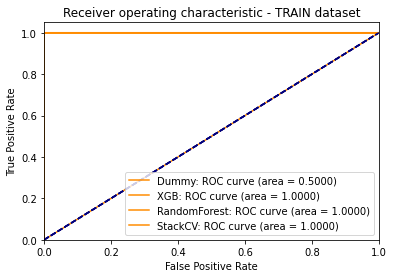

In [57]:
# Plot ROC curves
for model, label in zip(models, model_labels):
    
    # Calculate fpr, tpr for roc_curve
    y_pred_proba = model.predict_proba(X_train_t_res)[:, 1]
    fpr, tpr, _ = roc_curve(y_clf_train_t_res, y_pred_proba)
    
    # Calculate AUC
    auc = roc_auc_score(y_clf_train_t_res, y_pred_proba)
    
    plot_roc_curve(fpr, tpr, label)

Based on results above, we'll pick xgboost model as final classifier. Even though, Random Forest had slightly higher accuracy and lower variance, it has higher chance for overfitting. At the other hand, with this target feature (price_bin) it's really hard to investigate that fact, because every model is almost a perfect classifier (target variable is quite trivial function of price). Let's check it's effectiveness on unseen, test dataset.

In [58]:
preds = y_preds['XGB']['test']

print(classification_report(y_clf_test_t, preds))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      4011
           1       0.67      0.85      0.75       272

    accuracy                           0.96      4283
   macro avg       0.83      0.91      0.86      4283
weighted avg       0.97      0.96      0.97      4283



### 4.2 Regression model

### 4.2.1 Generating training data

In [59]:
target_mode = 'regression'

y_reg_train = y_all_train[target_cols[target_mode]]

# Feature engineering
X_train_t = FeatureEngineeringDF().fit_transform(X_train)

# Removing outliers
outlier_removal = OutlierRemovalDF(outlier_config)
outlier_removal.fit(X_train_t, y_reg_train)
X_train_t, y_reg_train_t = outlier_removal.transform(X_train_t, y_reg_train)

# Performing other steps: target encoding, log-scaling, one-hot-encoding
X_train_t = pd.concat([X_train_t, y_reg_train_t], axis=1)

X_train_t = pd.concat([
    X_train_t[passthrough_features],
    target_encoding_reg_pipeline.fit_transform(X_train_t),
    log_scaling_pipeline.fit_transform(X_train_t),
    one_hot_encoding_pipeline.fit_transform(X_train_t)
], axis=1)

X_train_t.columns

Index(['waterfront', 'month_sin', 'month_cos', 'day_of_month_sin',
       'day_of_month_cos', 'is_renovated', 'zipcode', 'grade',
       'sqft_living_log', 'sqft_lot_log', 'lat_log', 'long_log',
       'bedrooms_log', 'bathrooms_log', 'floors_log',
       'above_in_total_house_log', 'basement_in_total_house_log',
       'living_in_total_lot_log', 'house_age_log', 'renovation_age_log',
       'bathrooms_per_bedroom_log', 'living_per_bedroom_log',
       'living_per_floors_log', 'view_0', 'view_1', 'view_2', 'view_3',
       'view_4', 'condition_1', 'condition_2', 'condition_3', 'condition_4',
       'condition_5'],
      dtype='object')

### 4.2.2 Baseline model

In [60]:
dummy_reg = DummyRegressor(strategy='mean')
dummy_reg.fit(X_train_t, y_reg_train_t)

DummyRegressor()

### 4.2.3 Random Forest

In [61]:
rf_bayes_cv_tuner = BayesSearchCV(
    estimator = RandomForestRegressor(
        criterion='mse',
        n_jobs=-1,
        random_state=SEED
    ),
    search_spaces = {
        'n_estimators': Integer(100, 1000),
        'max_features': Categorical(['log2', 'sqrt']),
        'max_depth': Integer(10, 30),
        'min_samples_split': Real(1e-5, 1e-2)
    },    
    scoring = 'neg_mean_squared_error',
    cv = 10,
    n_jobs = 12,
    n_iter = 50,   
    verbose = 0,
    refit = True,
    random_state = SEED
)

rf_bayes_cv_tuner.fit(X_train_t, y_reg_train_t) # callback=status_print
    
print(f'Final results:\nValidation score: {rf_bayes_cv_tuner.best_score_}')
print(f'Best params:\n{str(rf_bayes_cv_tuner.best_params_)}')

/home/tom/Desktop/projects/house-pricing/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/tom/Desktop/projects/house-pricing/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/tom/Desktop/projects/house-pricing/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/tom/Desktop/projects/house-pricing/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/tom/Desktop/projects/house-pricing/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserW

Final results:
Validation score: -15860385686.037014
Best params:
OrderedDict([('max_depth', 20), ('max_features', 'log2'), ('min_samples_split', 1e-05), ('n_estimators', 980)])


### 4.2.4. Xgboost

In [62]:
xgb_bayes_cv_tuner = BayesSearchCV(
    estimator=xgb.XGBRegressor(
        n_jobs=-1,
        #objective='reg:squarederror',
        #eval_metric='rmse',
        silent=1,
        tree_method='approx'
    ),
    search_spaces = {
        'learning_rate': Real(0.01, 1.0, 'log-uniform'),
        'min_child_weight': Integer(1, 10,),
        'max_depth': Integer(1, 50),
        'max_delta_step': Integer(1, 20),
        'subsample': Real(0.01, 1.0, 'uniform'),
        'colsample_bytree': Real(0.01, 1.0, 'uniform'),
        'colsample_bylevel': Real(0.01, 1.0, 'uniform'),
        'reg_lambda': Real(1e-9, 1000, 'log-uniform'),
        'reg_alpha': Real(1e-9, 1.0, 'log-uniform'),
        'gamma': Real(1e-9, 0.5, 'log-uniform'),
        'min_child_weight': Integer(1, 5),
        'n_estimators': Integer(50, 150),
        'scale_pos_weight': Real(1e-6, 500, 'log-uniform')
    },    
    scoring='neg_mean_squared_error',
    cv=10,
    n_jobs=12,
    n_iter=50,   
    verbose=0,
    refit=True,
    random_state=SEED
)

xgb_bayes_cv_tuner.fit(X_train_t, y_reg_train_t)
    
print(f'Final results:\nValidation score: {xgb_bayes_cv_tuner.best_score_}')
print(f'Best params:\n{str(xgb_bayes_cv_tuner.best_params_)}')

[03:33:41] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Final results:
Validation score: -412906755021.5754
Best params:
OrderedDict([('colsample_bylevel', 1.0), ('colsample_bytree', 0.44920660732987094), ('gamma', 2.3089456670336376e-09), ('learning_rate', 1.0), ('max_delta_step', 20), ('max_depth', 1), ('min_child_weight', 3), ('n_estimators', 150), ('reg_alpha', 1.0), ('reg_lambda', 14.265733463950744), ('scale_pos_weight', 45.26887741711681), ('subsample', 1.0)])


### 4.2.X Preparing test data

In [63]:
target_mode = 'regression'

y_reg_test = y_all_test[target_cols[target_mode]]

# Feature engineering
X_test_t = FeatureEngineeringDF().transform(X_test)

# Removing outliers
X_test_t, y_reg_test_t = outlier_removal.transform(X_test_t, y_reg_test)

# Performing other steps: target encoding, log-scaling, one-hot-encoding
X_test_t = pd.concat([X_test_t, y_reg_test_t], axis=1)
X_test_t = pd.concat([
    X_test_t[passthrough_features],
    target_encoding_reg_pipeline.transform(X_test_t),
    log_scaling_pipeline.transform(X_test_t),
    one_hot_encoding_pipeline.transform(X_test_t)
], axis=1)

#X_test_t

### 4.2.X Evaluation of models and choosing the final one

In [64]:
#neg_root_mean_squared_error
models = [dummy_reg, xgb_bayes_cv_tuner.best_estimator_, rf_bayes_cv_tuner.best_estimator_]
model_labels = ['Dummy', 'XGB', 'RandomForest']
scores = {}
y_preds = {}

# Calculate average score - Kfold=10
for model, label in zip(models, model_labels):
    scores[label] = {
        'neg_root_mean_squared_error': cross_val_score(model, X_train_t, y_reg_train_t, cv=10, scoring='neg_root_mean_squared_error'),
        'r-square': cross_val_score(model, X_train_t, y_reg_train_t, cv=10, scoring='r2')
    }
    
    y_preds[label] = {
        'train': model.predict(X_train_t),
        'test': model.predict(X_test_t)
    }

[03:33:42] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:33:43] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:33:44] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:33:45] WARNING: ..

neg_root_mean_squared_error: -351637.5959 (+/- 15628.6735) [Dummy]
r-square: -0.0006 (+/- 0.0005) [Dummy]
neg_root_mean_squared_error: -642431.5737 (+/- 13726.9124) [XGB]
r-square: -2.3491 (+/- 0.1680) [XGB]
neg_root_mean_squared_error: -125765.6574 (+/- 6586.7369) [RandomForest]
r-square: 0.8720 (+/- 0.0039) [RandomForest]


/home/tom/Desktop/projects/house-pricing/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


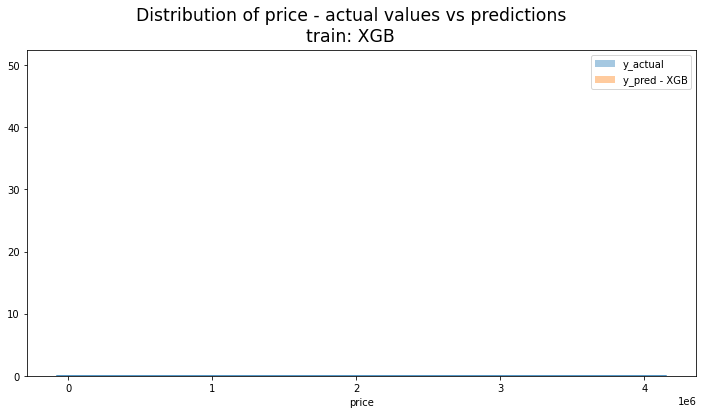

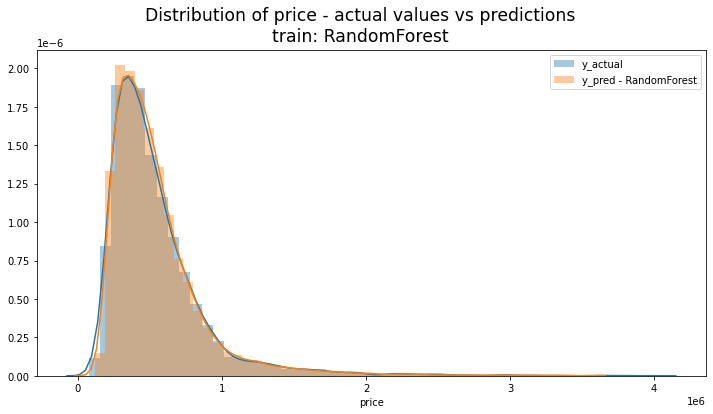

In [65]:
for model_label, value in scores.items():
    for metric, score in value.items():
        print(f'{metric}: {score.mean():0.4f} (+/- {score.std():0.4f}) [{model_label}]')

for model_label, value in y_preds.items():
    if model_label != 'Dummy':
        for dataset, preds in value.items():
            if (dataset == 'train'):
                plt.figure(figsize=(12,6))
                plt.suptitle(f'Distribution of price - actual values vs predictions\n{dataset}: {model_label}', fontsize='xx-large')
                sns.distplot(y_reg_train_t, kde=True, label='y_actual')
                sns.distplot(preds, kde=True, label=f'y_pred - {model_label}')
                plt.legend()
            

Unfortunately our XGBRegressor did not converge. Due to my personal limitation of time, I cannot cover debugging this. Therefore, we'll proceed with Random Forest regressor which has impressive performance on train dataset. Let's compare those results with those based on test dataset.

neg_root_mean_squared_error: -351637.5959 (+/- 15628.6735) [Dummy]
r-square: -0.0006 (+/- 0.0005) [Dummy]
neg_root_mean_squared_error: -642431.5737 (+/- 13726.9124) [XGB]
r-square: -2.3491 (+/- 0.1680) [XGB]
neg_root_mean_squared_error: -125765.6574 (+/- 6586.7369) [RandomForest]
r-square: 0.8720 (+/- 0.0039) [RandomForest]


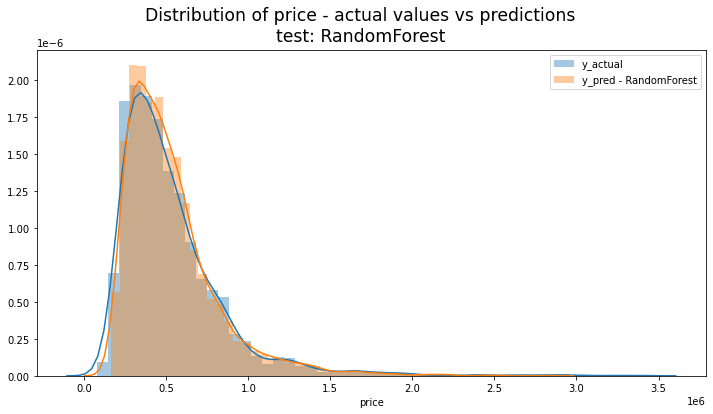

In [66]:
for model_label, value in scores.items():
    for metric, score in value.items():
        print(f'{metric}: {score.mean():0.4f} (+/- {score.std():0.4f}) [{model_label}]')

for model_label, value in y_preds.items():
    if model_label == 'RandomForest':
        for dataset, preds in value.items():
            if (dataset == 'test'):
                plt.figure(figsize=(12,6))
                plt.suptitle(f'Distribution of price - actual values vs predictions\n{dataset}: {model_label}', fontsize='xx-large')
                sns.distplot(y_reg_test_t, kde=True, label='y_actual')
                sns.distplot(preds, kde=True, label=f'y_pred - {model_label}')
                plt.legend()
            

## 5. Summary

In this notebook we covered end-to-end process of prototyping both classifier and regressor, including Explanataory data analysis and preprocessing using custom pipelines. For classification problem we built tree-based models and their ensembled version (Stacking). Hyperparameters were tuned using Cross Validated Bayesian search using skopt package. For regression problem we followed similiar path. <br>
For each problem, one model was chosen and evaluated on test dataset. Results are satisfying, while taking in account how much time was spent on this project.

## 6. Next steps in project

For the next steps that we would take to improve our solution, are the following:
- Get more information about project assumptions, limitations, expectations to be able to wisely choose appropriate tools to solve this task.
- Investigate fact of duplicates in our dataset (questions to data owner or Data Engineer)
- Get information about ommited features (suffix: _15) to be able to use them as models' features
- Try another transformations for numerical features - e.g. Box-Cox transformation instead of log-scaling
- Try another approaches for outlier removal. Another methods, value-capping instead of deleting those rows
- Spend more time on feature engineering - especially on part of geo-localization data. We didn't find sufficient amount of time to use external resources to match with our data.
- Perform research about external data that might be useful
- Investivate the fact of not converging XGB regressor in regression problem
- Build another types of models - out of tree-family
- Perform models ensemble and optimize the weights to achieve the best performance
- Improve preprocessing pipeline - putting meta-pipeline to cover whole preprocessing part. In addition include model prototyping as pipeline as well for easier, further, model prototyping.
- Calculate more performance measures to be able to easier our results to us, our team and potentional clients
- Consider another Cross validation method - TimeSplitCV and check vulnerability of our model to time factor (looking for trend).
- Investigate and calibrate sampling ratio for oversampling process
- Analyze loss function by investigating results with the higher loss.
- Re-evaluate project's assumptions and approach with 3rd party.
- Do code refactoring - put functions and classes out of jupyter notebook, improve repo structure. In addition extend doc-strings and documentation overall.